In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants, interpolate
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks, savgol_filter
import glob
import os


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_cap(file):
    data = pd.read_csv(file, sep='\t',skiprows=([i for i in range(0, 20)] +
                                                [j for j in range(422, 829)]), usecols=['Bias', 'Data Trace Real'])
    data['1_over_C2'] = data['Data Trace Real'].apply(lambda x: 1/x**2)
    return data.rename(columns={'Data Trace Real': 'Capacity'})
    
    
def read_cond(file):
    data = pd.read_csv(file, sep='\t',skiprows=427, usecols=['Bias', 'Data Trace Real'])
    return data.rename(columns={'Data Trace Real': 'Conductivity'})

In [118]:
VAC_300 = (pd.read_csv('[2]VAC[18].txt', sep='\t'))
VAC_200 = (pd.read_csv('[2]VAC[20].txt', sep='\t'))
VAC_100 = (pd.read_csv('[2]VAC[21].txt', sep='\t'))
VAC_50 = (pd.read_csv('[2]VAC[23].txt', sep='\t'))

VAC_300 = VAC_300.replace(',', '.', regex=True).drop(columns=['N'], axis=1)
VAC_200 = VAC_200.replace(',', '.', regex=True).drop(columns=['N'], axis=1)
VAC_100 = VAC_100.replace(',', '.', regex=True).drop(columns=['N'], axis=1)
VAC_50 = VAC_50.replace(',', '.', regex=True).drop(columns=['N'], axis=1)

In [119]:
list_VAC = [VAC_300, VAC_200, VAC_100, VAC_50]
for name in list_VAC:
    name.Volt = pd.to_numeric(name.Volt)
    name.Amp = pd.to_numeric(name.Amp).abs()

In [98]:
cond_100K300 = read_cond('D100K300.TXT')
cond_10K300 = read_cond('D10K300.TXT') 
cond_1K300 = read_cond('D1K300.TXT')
cond_1M300 = read_cond('D1M300.TXT') 

cond_100K200 = read_cond('D100K200.TXT')
cond_10K200 = read_cond('D10K200.TXT') 
cond_1K200 = read_cond('D1K200.TXT')
cond_1M200 = read_cond('D1M200.TXT') 

cond_100K100 = read_cond('D100K100.TXT')
cond_10K100 = read_cond('D10K100.TXT') 
cond_1K100 = read_cond('D1K100.TXT')
cond_1M100 = read_cond('D1M100.TXT')

cond_100K50 = read_cond('D100K50.TXT')
cond_10K50 = read_cond('D10K50.TXT') 
cond_1K50 = read_cond('D1K50.TXT')
cond_1M50 = read_cond('D1M50.TXT')

In [100]:
cap_100K300 = read_cap('D100K300.TXT')
cap_10K300 = read_cap('D10K300.TXT') 
cap_1K300 = read_cap('D1K300.TXT')
cap_1M300 = read_cap('D1M300.TXT') 

cap_100K200 = read_cap('D100K200.TXT')
cap_10K200 = read_cap('D10K200.TXT') 
cap_1K200 = read_cap('D1K200.TXT')
cap_1M200 = read_cap('D1M200.TXT') 

cap_100K100 = read_cap('D100K100.TXT')
cap_10K100 = read_cap('D10K100.TXT') 
cap_1K100 = read_cap('D1K100.TXT')
cap_1M100 = read_cap('D1M100.TXT') 

cap_100K50 = read_cap('D100K50.TXT')
cap_10K50 = read_cap('D10K50.TXT') 
cap_1K50 = read_cap('D1K50.TXT')
cap_1M50 = read_cap('D1M50.TXT') 

In [102]:
cap_list_300 = [cap_1M300, cap_100K300, cap_10K300, cap_1K300]
cond_list_300 = [cond_1M300, cond_100K300, cond_10K300, cond_1K300]

cap_list_200 = [cap_1M200, cap_100K200, cap_10K200, cap_1K200]
cond_list_200 = [cond_1M200, cond_100K200, cond_10K200, cond_1K200]

cap_list_100 = [cap_1M100, cap_100K100, cap_10K100, cap_1K100]
cond_list_100 = [cond_1M100, cond_100K100, cond_10K100, cond_1K100]

cap_list_50 = [cap_1M50, cap_100K50, cap_10K50, cap_1K50]
cond_list_50 = [cond_1M50, cond_100K50, cond_10K50, cond_1K50]

In [310]:
cap_list_300n = [cap_1M300, cap_100K300, cap_10K300]
cap_list_200n = [cap_1M200, cap_100K200, cap_10K200]
cap_list_100n = [cap_1M100, cap_100K100, cap_10K100]
cap_list_50n = [cap_1M50, cap_100K50, cap_10K50]

In [292]:
for list  in [cap_list_300,cap_list_200,cap_list_100,cap_list_50]:
    for data in list:
        data = data.loc[data['Bias']<1.5]


In [76]:
freqs = ['1MHz', '100KHz', '10KHz', '1KHz']
Temps = [50, 100, 200, 300]
eps = 9.7
N_c = []

for i in [300, 200,100, 50]:
    N_c.append((2 * np.sqrt(2*constants.pi*0.2*constants.m_e*constants.k*i/((constants.h*100)**2))**3).round(-15))
    
print('N_c =', N_c)

N_c = [2.244e+18, 1.222e+18, 4.32e+17, 1.53e+17]


In [347]:
def cv_all(list, T, lim_V1,lim_V2, lim_C):
    fig, axs = plt.subplots(figsize=(20,12))
    axs.xaxis.set_major_locator(MultipleLocator(0.5))
#     axs.yaxis.set_major_locator(MultipleLocator(5e-10))
    for data in list:
        plt.scatter(data['Bias'].loc[(data['Bias']>lim_V1) & (data['Bias']<lim_V2)&(data['Capacity']>lim_C)],
                 savgol_filter(data['Capacity'].loc[(data['Bias']>lim_V1) & (data['Bias']<lim_V2)&(data['Capacity']>lim_C)],5, 2, mode='interp'))
    plt.legend(('1MHz', '100KHz', '10KHz', '1KHz'), loc=(0.2, 0.65), handlelength=1.5, fontsize=16)
    plt.title(' Вольт-фарадная характеристика при {}K'.format(T), fontsize=18)     
    plt.xlabel('Bias, V', fontsize=18)
    plt.ylabel('Capacitance *10^-8, F', fontsize=18)
    plt.grid()
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
#     fig.savefig('Graphs/cv_all_{0}.png'.format(T))
    

In [348]:
def gv_all(list, T, lim_V1,lim_V2):
    fig, axs = plt.subplots(figsize=(20,12))
    axs.xaxis.set_major_locator(MultipleLocator(0.5))
#     axs.yaxis.set_major_locator(MultipleLocator())
    for data in list:
        plt.scatter(data['Bias'].loc[(data['Bias']>lim_V1) & (data['Bias']<lim_V2)],
                 data['Conductivity'].loc[(data['Bias']>lim_V1) & (data['Bias']<lim_V2)])
    plt.legend(('1MHz', '100KHz', '10KHz', '1KHz'), loc=(0.25, 0.65), handlelength=1.5, fontsize=16)
        
    plt.title(' Зависимость проводимости от напряжения при {}K'.format(T), fontsize=18)     
    plt.xlabel('Bias, V', fontsize=18)
    plt.ylabel('Conductivity, S', fontsize=18)
    plt.grid()
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
#     fig.savefig('Graphs/gv_all_{0}.png'.format(T))

In [339]:
def cv_plot(list, T, lim_C2, lim_V1, lim_V2):
    i = 0
    for data in list:
        fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 0.25, 'wspace': 0.3}, figsize=(20,8))

        plt.subplot(121)
        plt.plot(data['Bias'].loc[data['Bias']<1.1],data['Capacity'].loc[data['Bias']<1.1])
        plt.title(' Вольт-фарадная характеристика при {0}K {1}'.format(T, freqs[i]),fontsize=16)
        plt.xlabel('Bias, V',fontsize=18)
        plt.ylabel('Capacitance, F',fontsize=18)
        plt.tick_params(axis='x', labelsize=18)
        plt.tick_params(axis='y', labelsize=18)
        plt.grid()
        
        plt.subplot(122)
        plt.scatter(data['Bias'].loc[(data['1_over_C2']>lim_C2) & (data['Bias'] < lim_V2) & (data['Bias'] > lim_V1)],
                    data['1_over_C2'].loc[(data['1_over_C2']>lim_C2) & (data['Bias'] < lim_V2) & (data['Bias'] > lim_V1)])
        plt.title(' 1/C^2 от U',fontsize=16)
        plt.xlabel('Bias, V',fontsize=18)
        plt.ylabel('1/C^2, 1/F^2',fontsize=18)
        plt.grid()
        
        plt.tick_params(axis='x', labelsize=18)
        plt.tick_params(axis='y', labelsize=18)
        
#         fig.savefig('Graphs/cv_plot_{0}K_{1}.png'.format(T, freqs[i]))
        i+=1

In [278]:
S = 1e-3
# Определение параметров из CV
def params(data, x1, x2, i, T):
#    x1 - left bias lim
#    x2 - right bias lim
#    i  - iteration number 
    coefficients = 0
    V_d = 0
    N_d = 0
    coefficients = np.polyfit(data['Bias'].loc[(data['Bias']>x1)&(data['Bias']<x2)], 
                              y=data['1_over_C2'].loc[(data['Bias']>x1) & (data['Bias']<x2)], deg=1)
    polynom = np.poly1d(coefficients)
    V_d = coefficients[0]/coefficients[1]                                                                                         
    N_d = abs(2/(constants.e*constants.epsilon_0*S**2*eps)/polynom[1])
    print(polynom)
    print('V_d = ', V_d.round(2),'B')
    print('N_d =',   f'{N_d:.2e}')
    print('E_C - E_F = ', (constants.k * T * np.log(N_c[i]/N_d)/constants.e).round(3), 'eV')

In [340]:
# График ВФХ и отдельного линейного участка
# Рассчитываем потенциал и сопротивление базы
def VAC_plot(data, V1, V2, T):
    fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 0.25, 'wspace': 0.3}, figsize=(20,10))
    
    plt.subplot(121)
    plt.plot(data['Volt'],data['Amp'])
    plt.title(' Вольт-амперная характеристика. T={} K'.format(T), fontsize=18)
    plt.xlabel('U, V',fontsize=18)
    plt.ylabel('I, A',fontsize=18)
    plt.grid()
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.yscale('log')

    plt.subplot(122)
    plt.plot(data['Volt'].loc[(data['Volt']>V1)&(data['Volt']<V2)],
             np.log(data['Amp'].loc[(data['Volt']>V1)&(data['Volt']<V2)]))
    plt.title('Линейный участок кривой',fontsize=18)
    plt.xlabel('U, V',fontsize=18)
    plt.ylabel('I, A',fontsize=18)
    coefficients = np.polyfit(data['Volt'].loc[(data['Volt']>V1)&(data['Volt']<V2)],
                              np.log(data['Amp'].loc[(data['Volt']>V1)&(data['Volt']<V2)]), deg=1)
    poly = np.poly1d(coefficients)
    lin_fit = poly(data['Volt'].loc[(data['Volt']>V1)&(data['Volt']<V2)])
    plt.plot(data['Volt'].loc[(data['Volt']>V1)&(data['Volt']<V2)], lin_fit, color='red')
    
    plt.grid()
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
    I_0 = np.exp(poly[0])
    R = (1/poly[1]).round(2)
    phi_B = (np.exp(poly[0])*poly[1]).round(2)

    print('Уравненение апроксимационной прямой при T={} K'.format(t), poly)
    print('Рассчитанные параметры:')
    print('I_0 = ', f'{np.exp(poly[0]):.2e}', 'A')
    print('R = ',  (1/poly[1]).round(2), 'Ohm')
    print('phi_b = ', (poly[1]/poly[0]).round(2), 'V')
#     plt.savefig('Graphs/VAC_{}.png'.format(T))

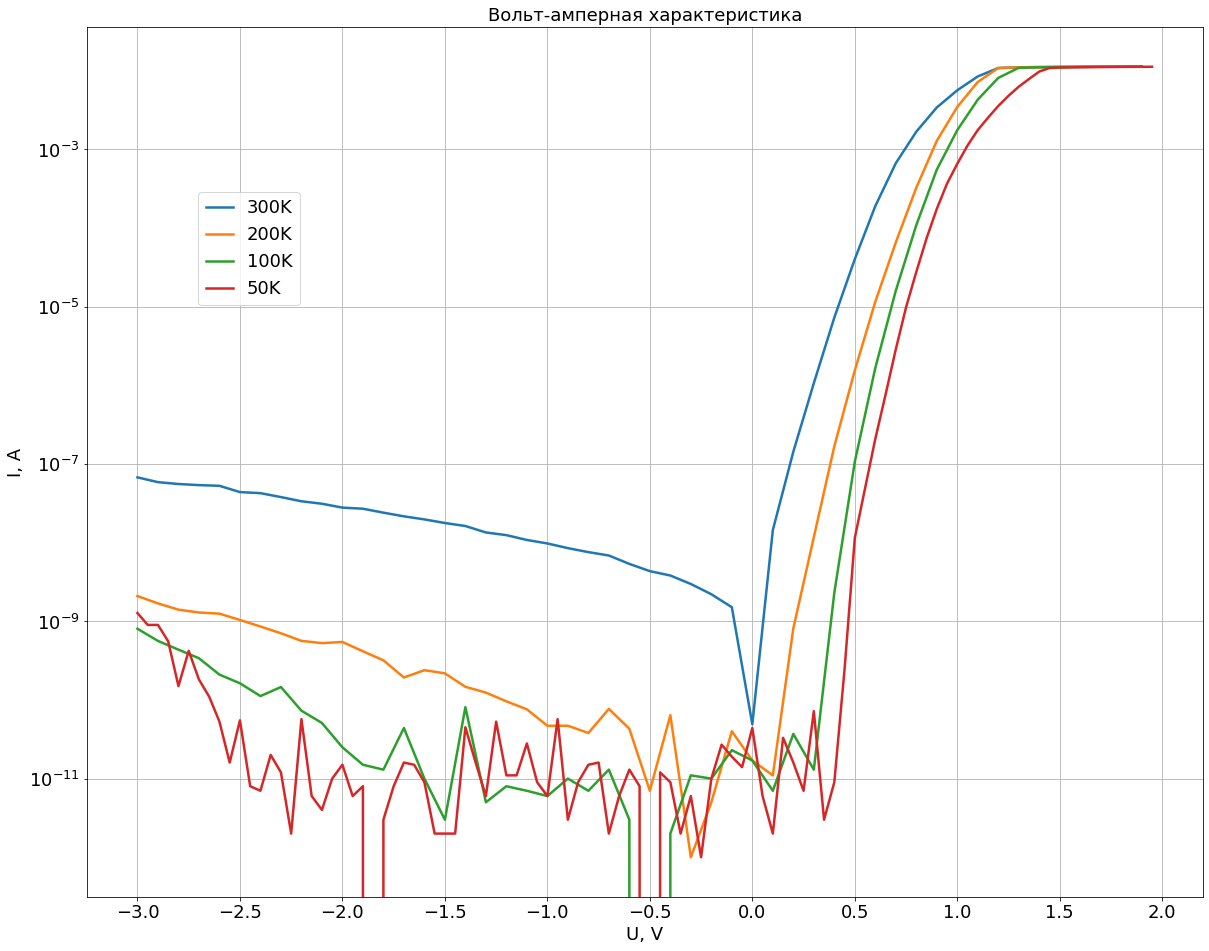

In [341]:
fig, axs = plt.subplots(figsize=(20,16))

axs.xaxis.set_major_locator(MultipleLocator(0.5))
for nm in list_VAC:
    axs = plt.plot(nm['Volt'].loc[nm['Volt']<2], nm['Amp'].loc[nm['Volt']<2],linewidth=2.5)

plt.yscale('log')

plt.title('Вольт-амперная характеристика', fontsize=18)
plt.legend(('300K', '200K','100K', '50K'), loc=(0.1, 0.68), handlelength=1.5, fontsize=18)
plt.xlabel('U, V',fontsize=18)
plt.ylabel('I, A',fontsize=18)

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)


plt.grid()
# plt.savefig('Graphs/VAC_all_Temps.png')

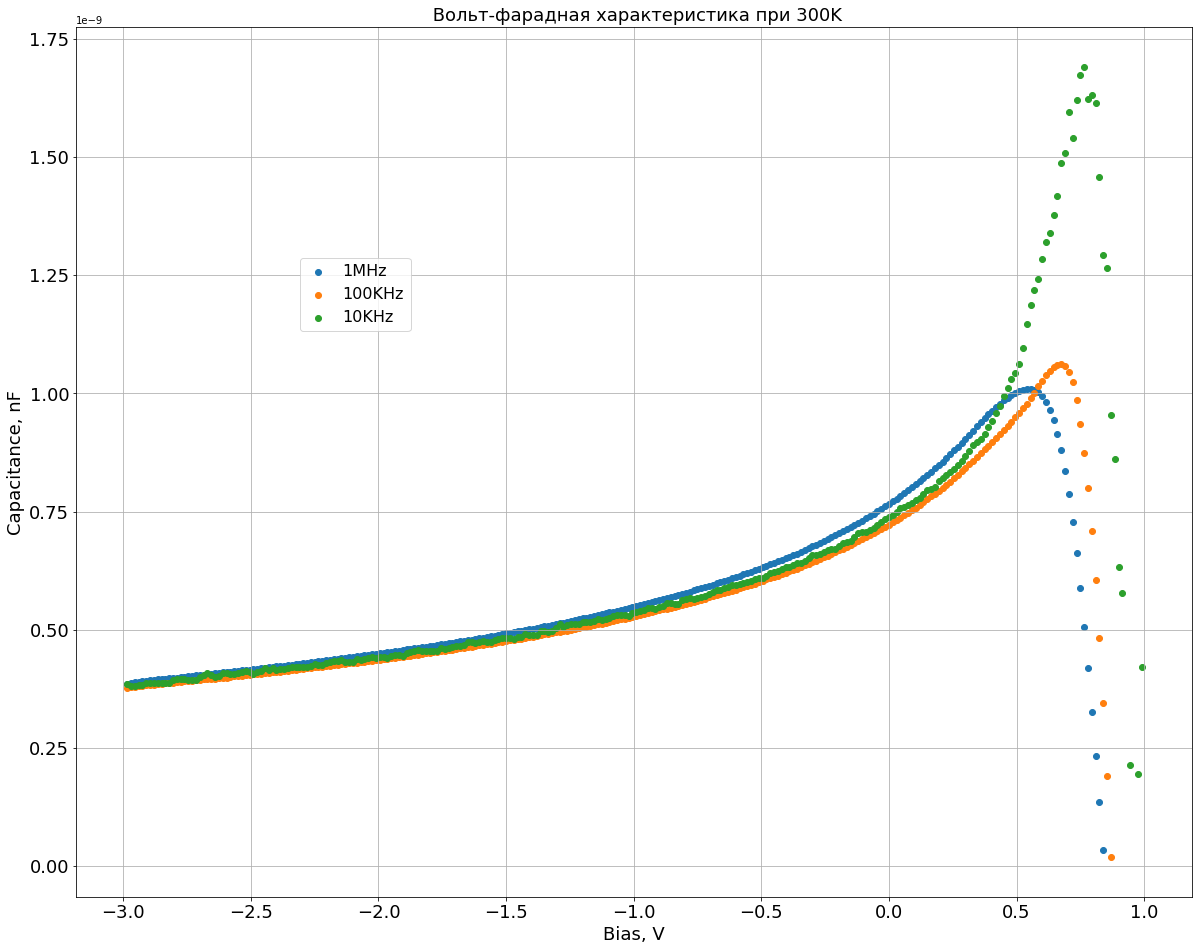

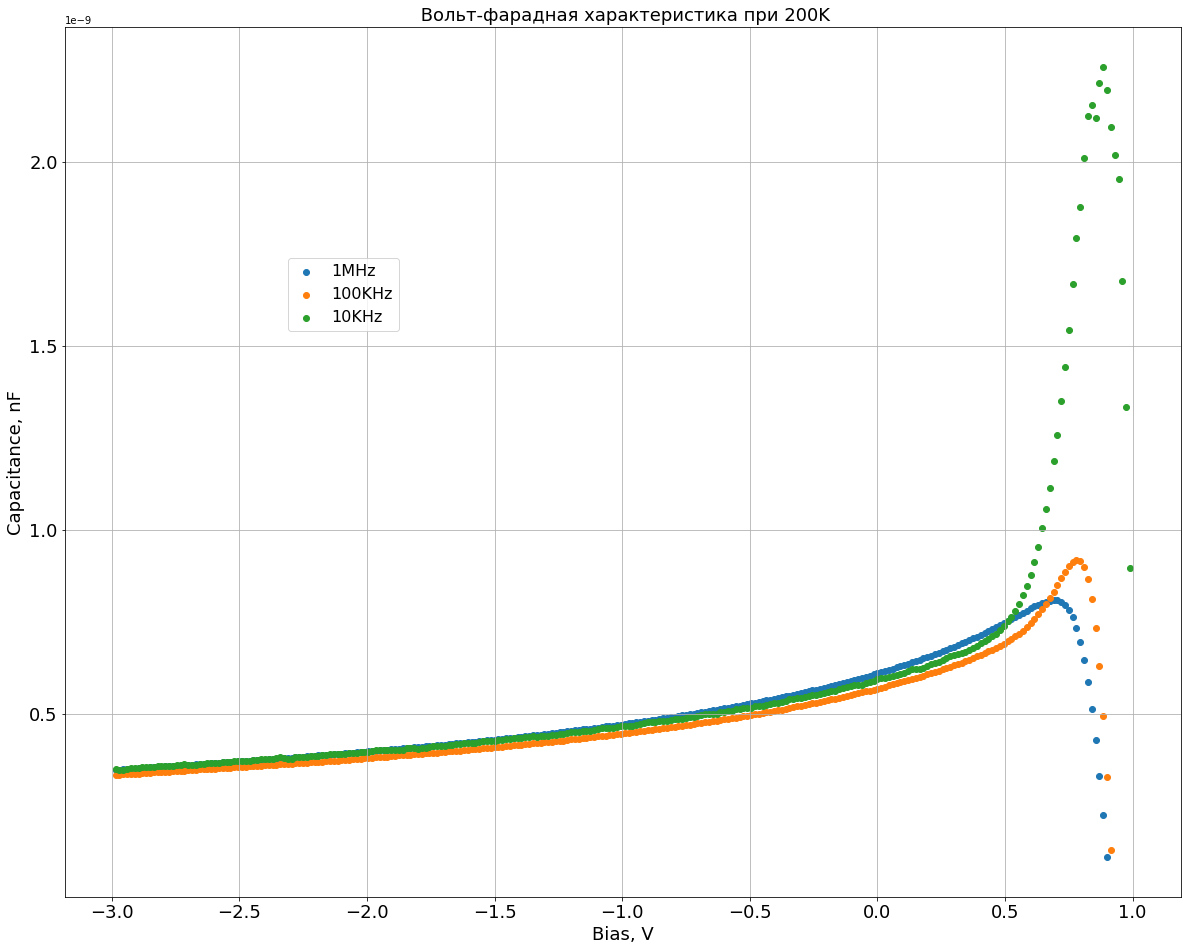

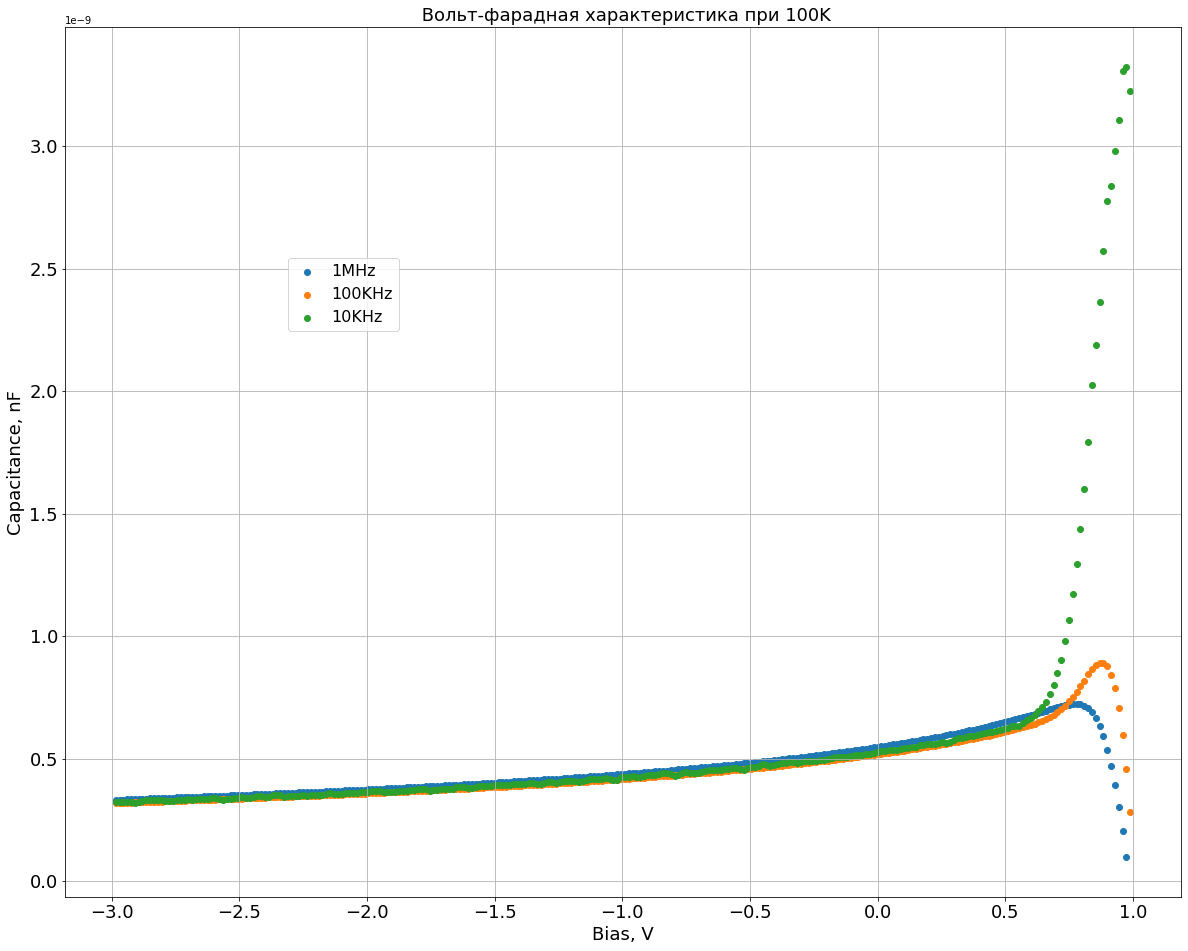

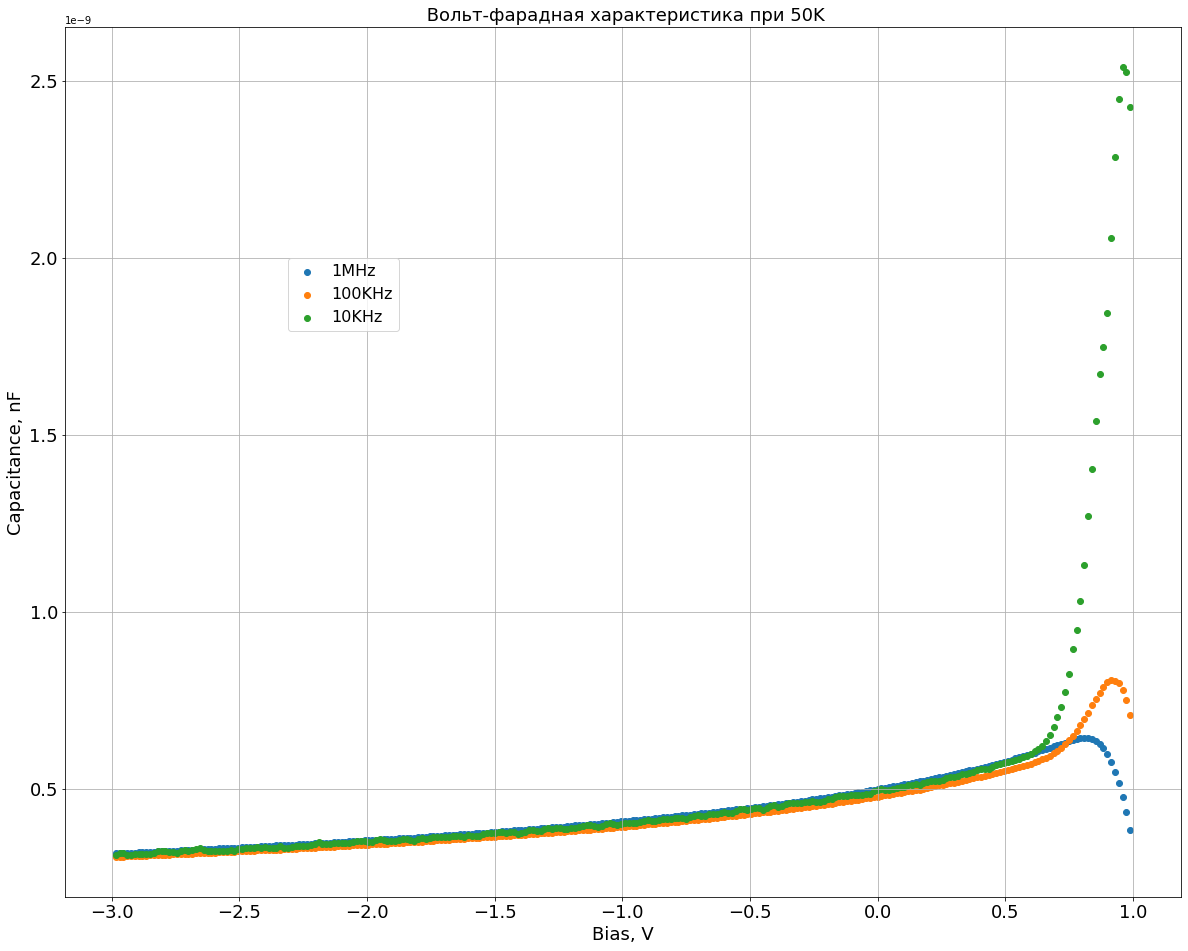

In [314]:
cv_all(cap_list_300n, 300, -3, 1, 0)
cv_all(cap_list_200n, 200, -3, 1, 0)
cv_all(cap_list_100n, 100, -3, 1, 0)
cv_all(cap_list_50n, 50, -3, 1, 0)

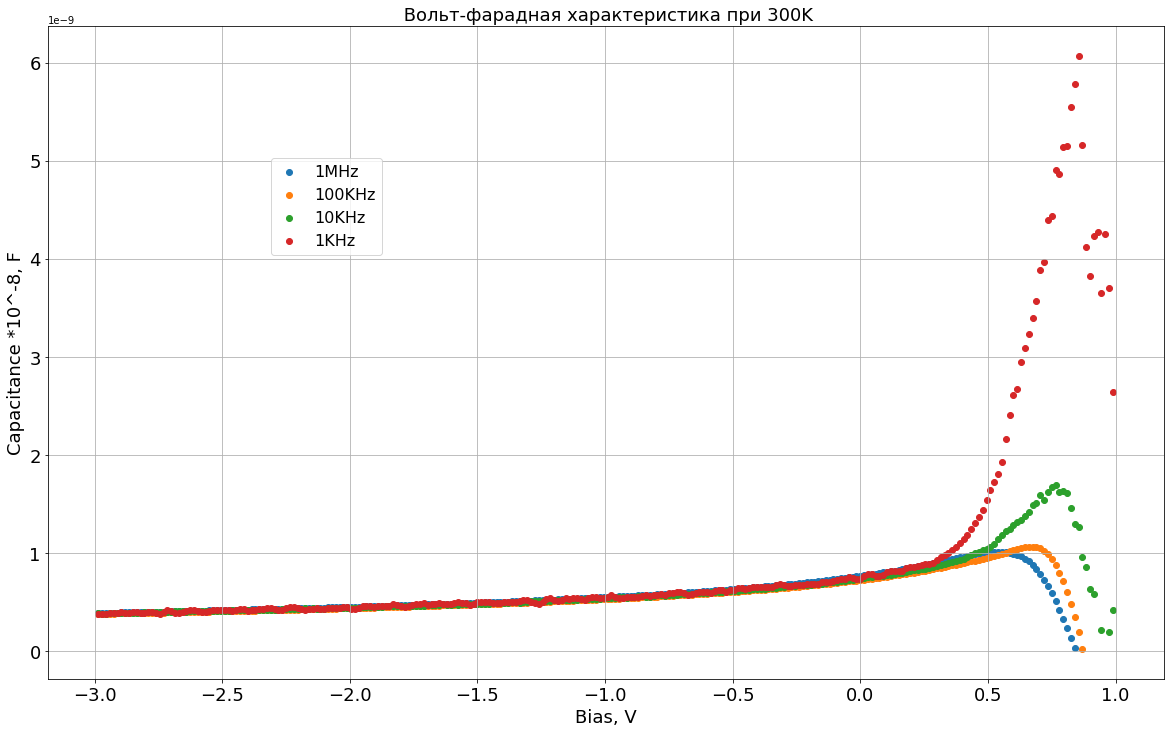

In [349]:
cv_all(cap_list_300, 300, -3, 1, 0)

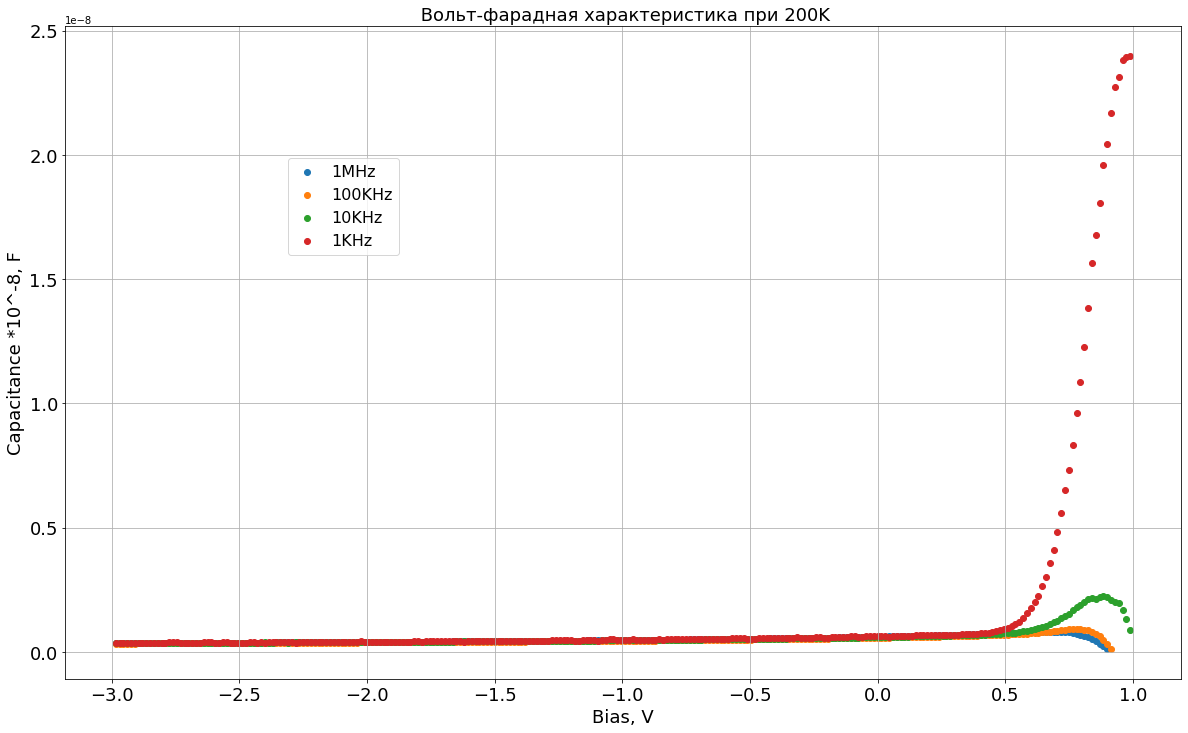

In [350]:
cv_all(cap_list_200, 200, -3, 1, 0)

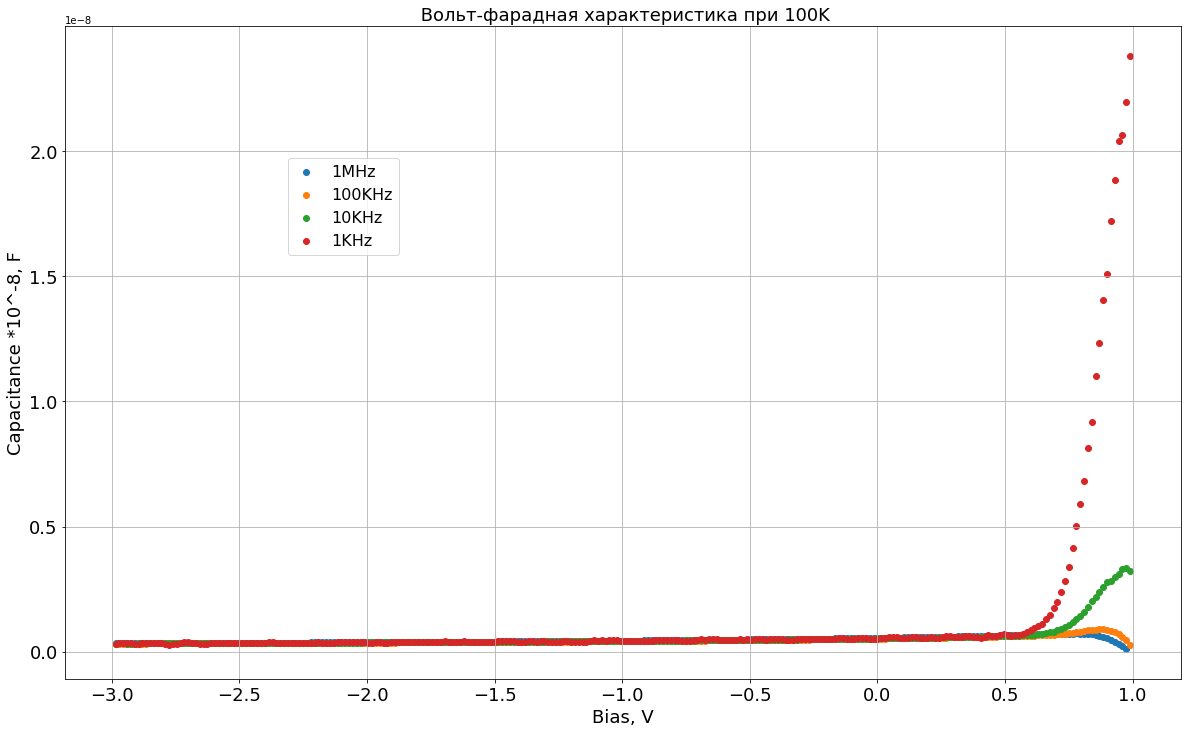

In [351]:
cv_all(cap_list_100, 100, -3, 1, 0)

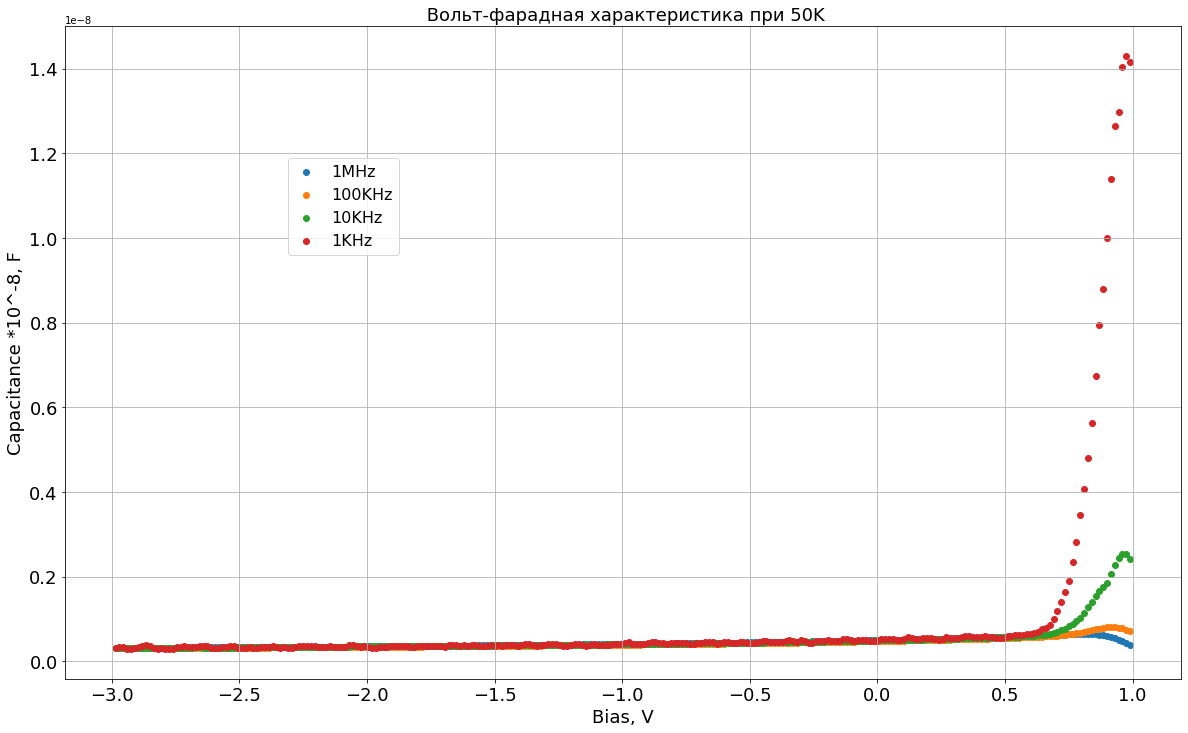

In [352]:
cv_all(cap_list_50, 50, -3, 1, 0)

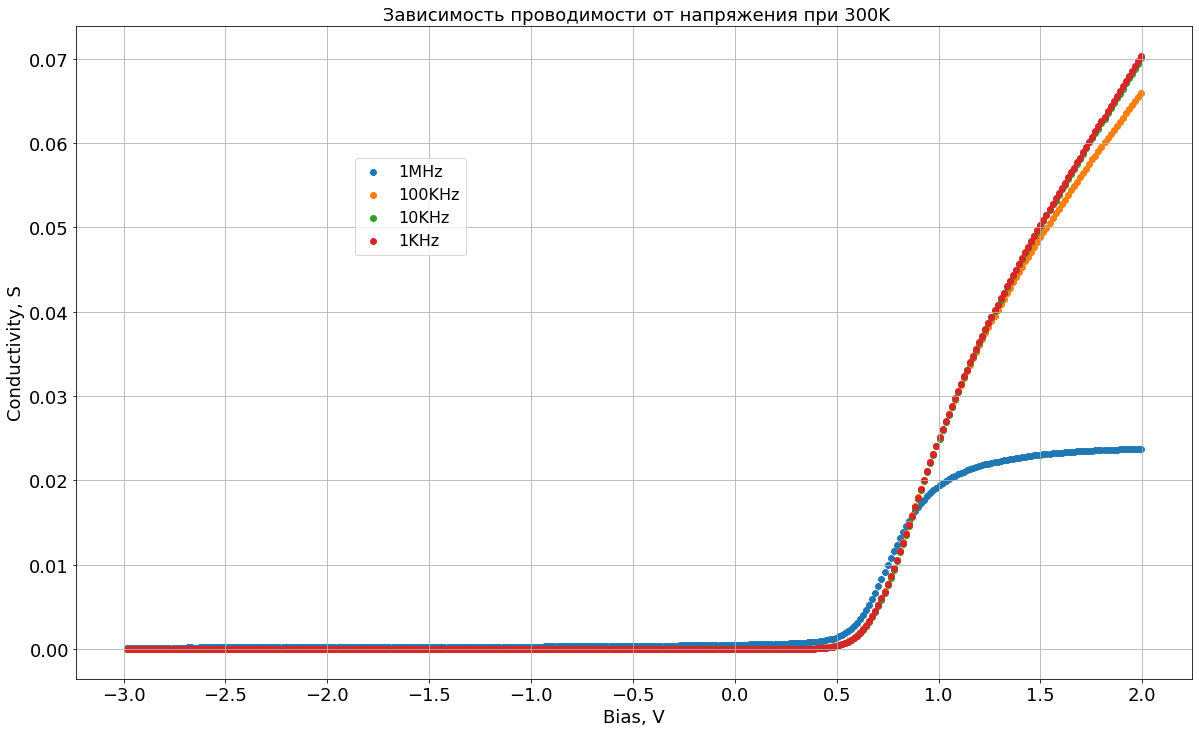

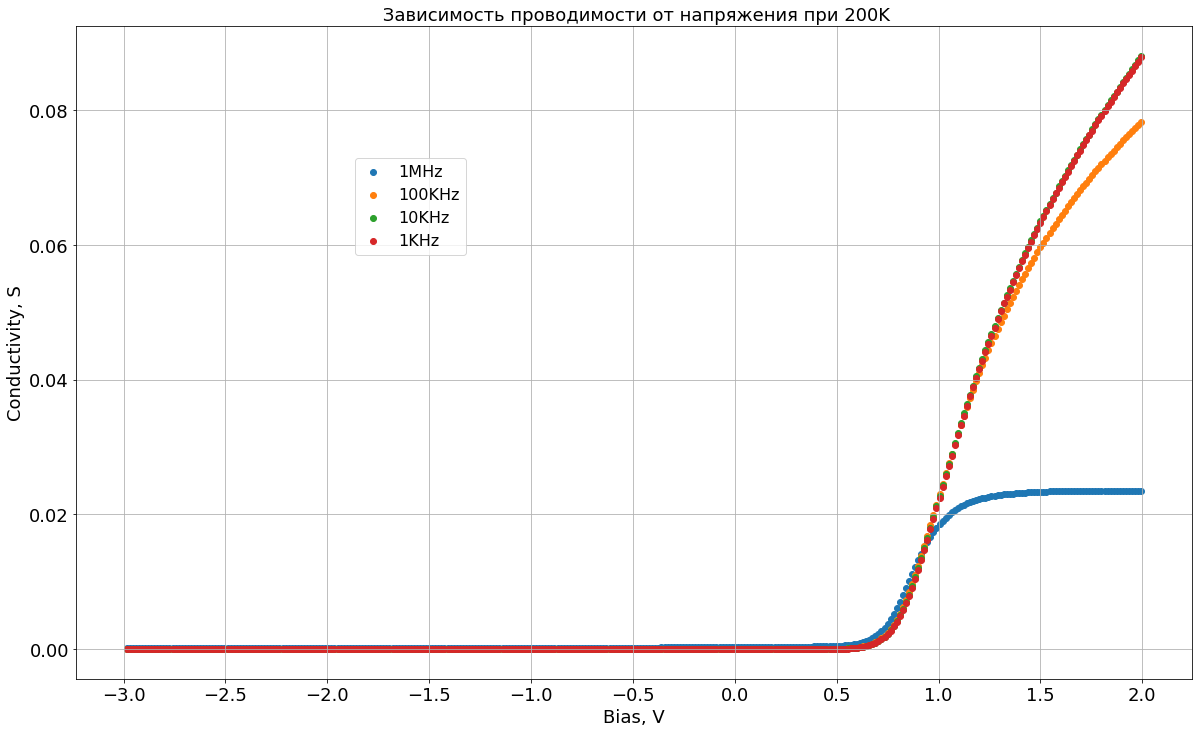

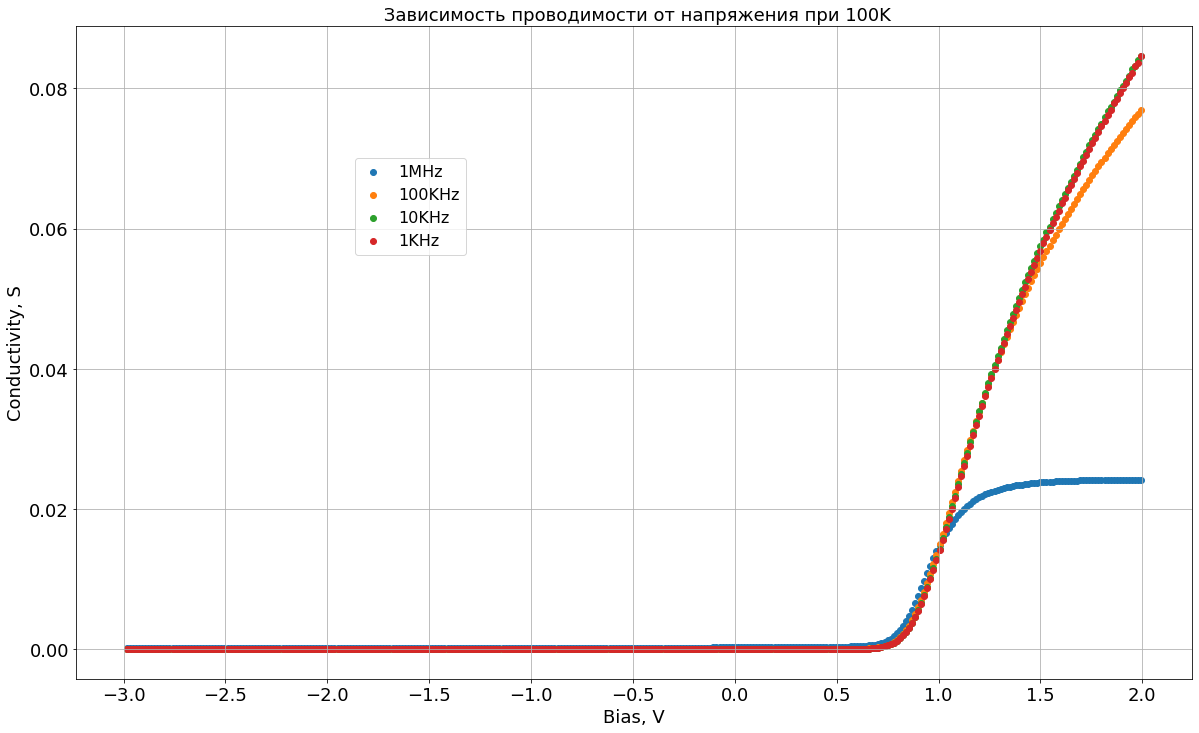

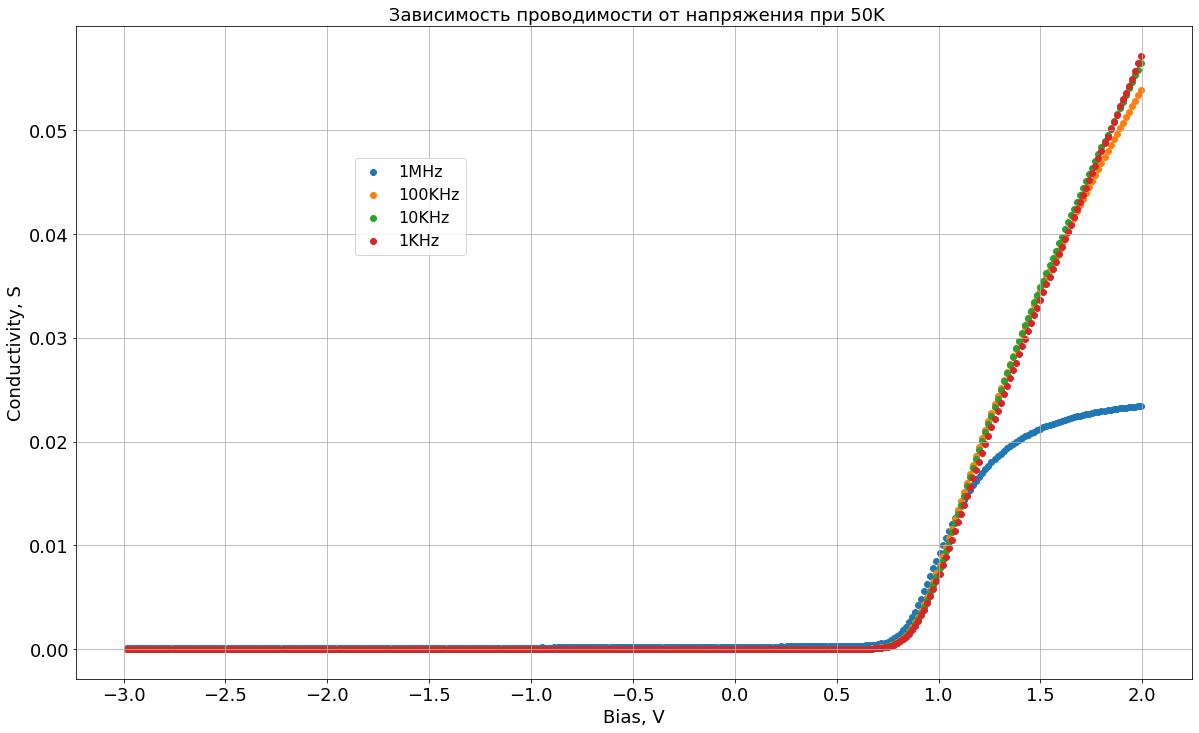

In [353]:
gv_all(cond_list_300, 300, -3, 2)
gv_all(cond_list_200, 200, -3, 2)
gv_all(cond_list_100, 100, -3, 2)
gv_all(cond_list_50, 50, -3, 2)

In [197]:
limit_list_right = [0.4, 0.5, 0.6, 0.4]
limit_list_left = [0.7, 0.8, 0.8, 0.8]

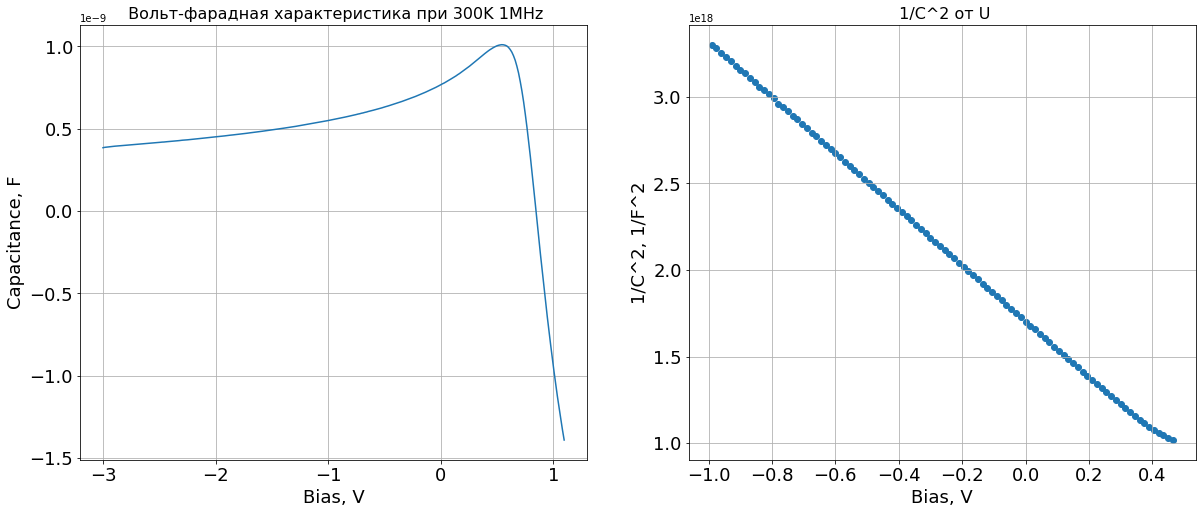

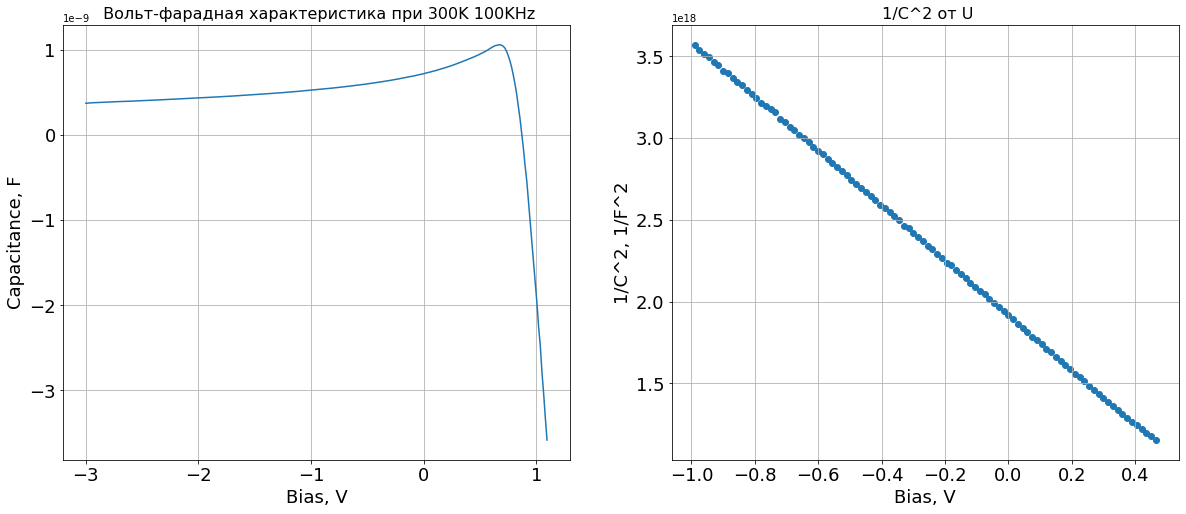

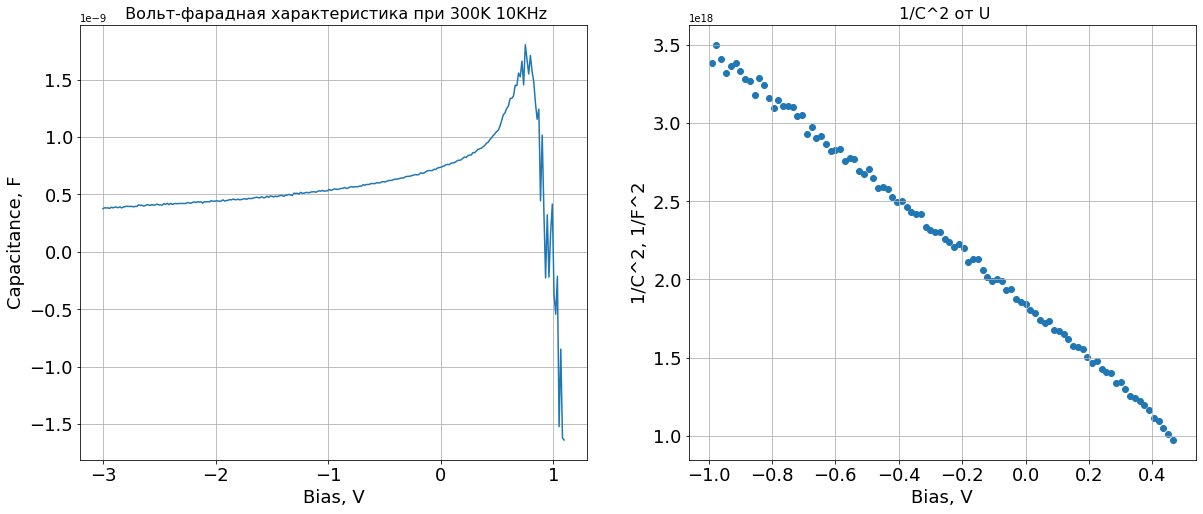

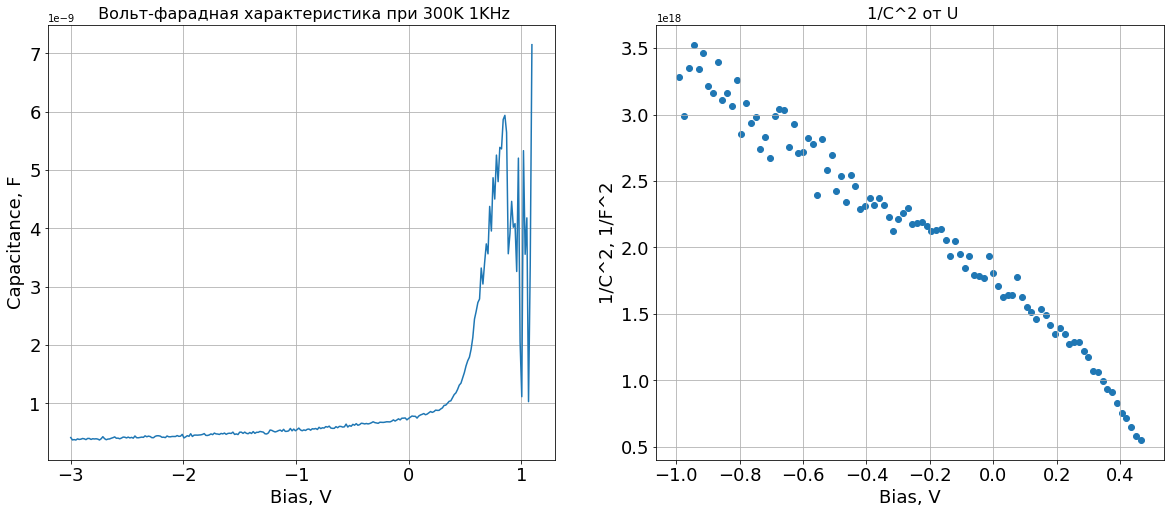

In [329]:
cv_plot(cap_list_300, 300, -6e-8, -1, 0.47)

In [330]:
limit_list_right = [0.4, 0.5, 0.6, 0.4]
limit_list_left = [-1, -1, -1, -1]
i = 0
print('При температуре 300К')
for item in cap_list_300:
    print('Параметры для частоты', freqs[i])
    params(item, limit_list_left[i], limit_list_right[i], i, Temps[i])
    i+=1
    print()

При температуре 300К
Параметры для частоты 1MHz
 
-1.612e+18 x + 1.706e+18
V_d =  -0.95 B
N_d = 9.02e+16
E_C - E_F =  0.014 eV

Параметры для частоты 100KHz
 
-1.671e+18 x + 1.917e+18
V_d =  -0.87 B
N_d = 8.70e+16
E_C - E_F =  0.023 eV

Параметры для частоты 10KHz
 
-1.709e+18 x + 1.811e+18
V_d =  -0.94 B
N_d = 8.50e+16
E_C - E_F =  0.028 eV

Параметры для частоты 1KHz
 
-1.706e+18 x + 1.716e+18
V_d =  -0.99 B
N_d = 8.52e+16
E_C - E_F =  0.015 eV



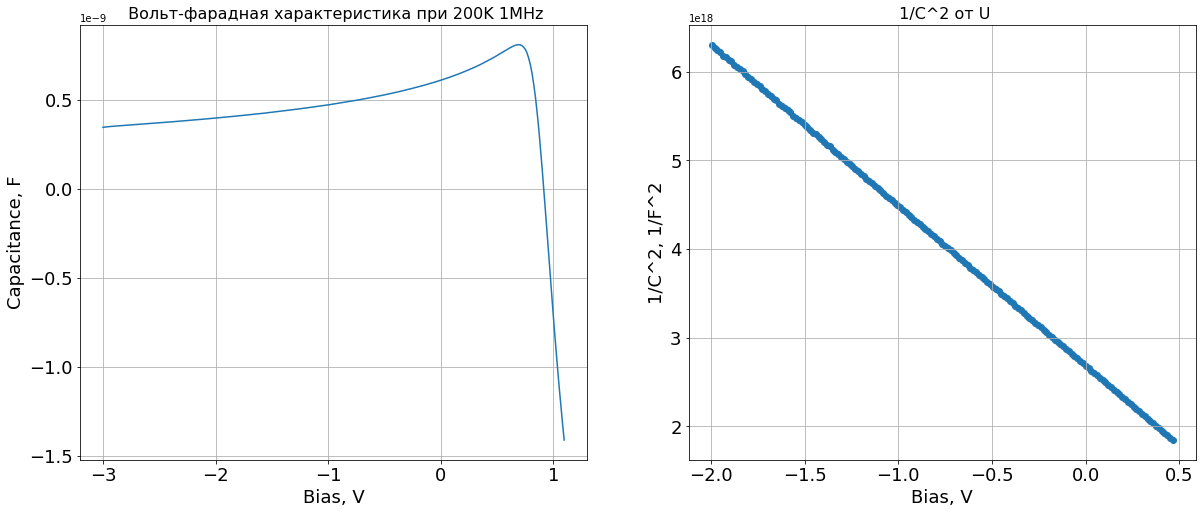

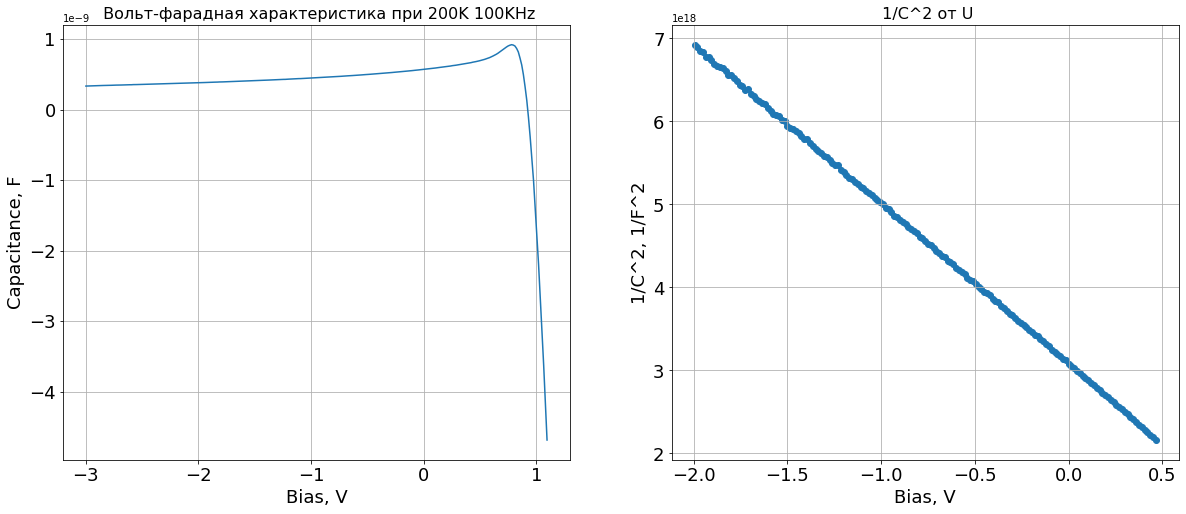

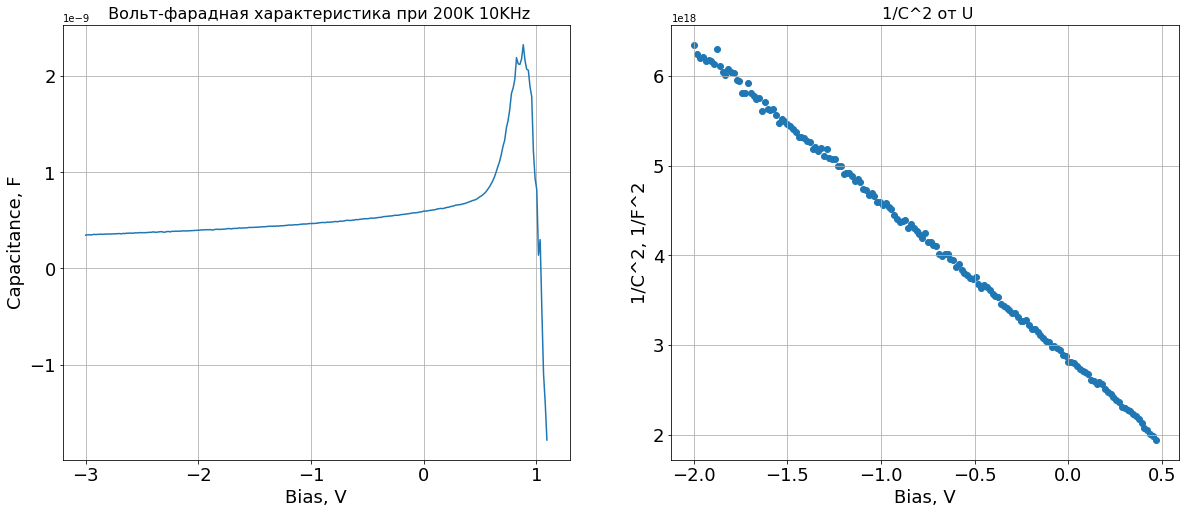

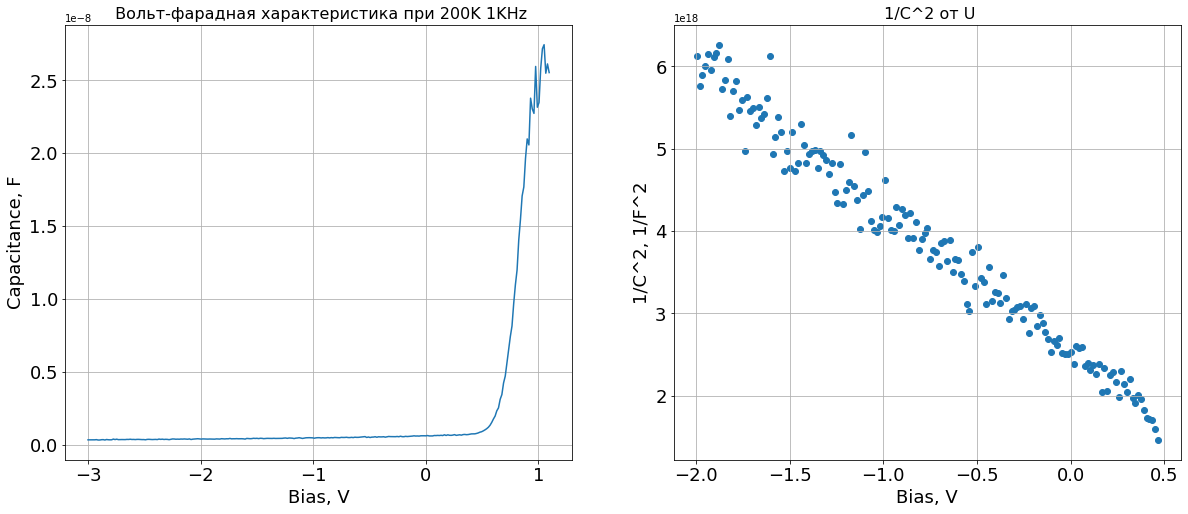

In [331]:
cv_plot(cap_list_200, 200, -6e-8, -2, 0.47)

In [332]:
limit_list_right = [0.5, 0.5, 0.4, 0.4]
limit_list_left = [-2, -2, -2, -2]
i = 0
print('При температуре 200К')
for item in cap_list_200:
    print('Параметры для частоты', freqs[i])
    params(item, limit_list_left[i], limit_list_right[i], i, Temps[i])
    i+=1
    print()

При температуре 200К
Параметры для частоты 1MHz
 
-1.81e+18 x + 2.681e+18
V_d =  -0.67 B
N_d = 8.03e+16
E_C - E_F =  0.014 eV

Параметры для частоты 100KHz
 
-1.923e+18 x + 3.082e+18
V_d =  -0.62 B
N_d = 7.56e+16
E_C - E_F =  0.024 eV

Параметры для частоты 10KHz
 
-1.75e+18 x + 2.846e+18
V_d =  -0.61 B
N_d = 8.31e+16
E_C - E_F =  0.028 eV

Параметры для частоты 1KHz
 
-1.727e+18 x + 2.546e+18
V_d =  -0.68 B
N_d = 8.41e+16
E_C - E_F =  0.015 eV



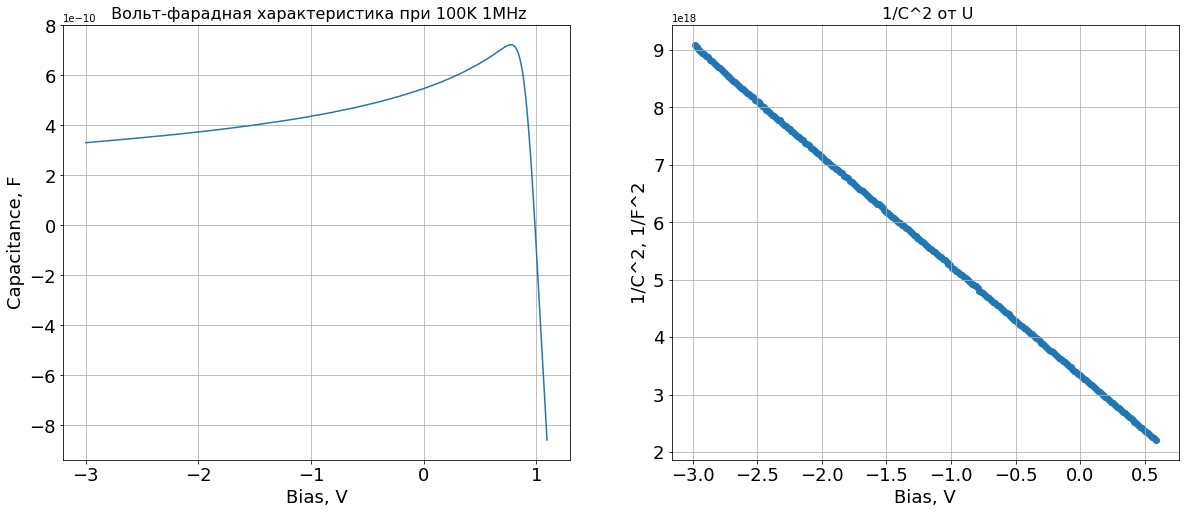

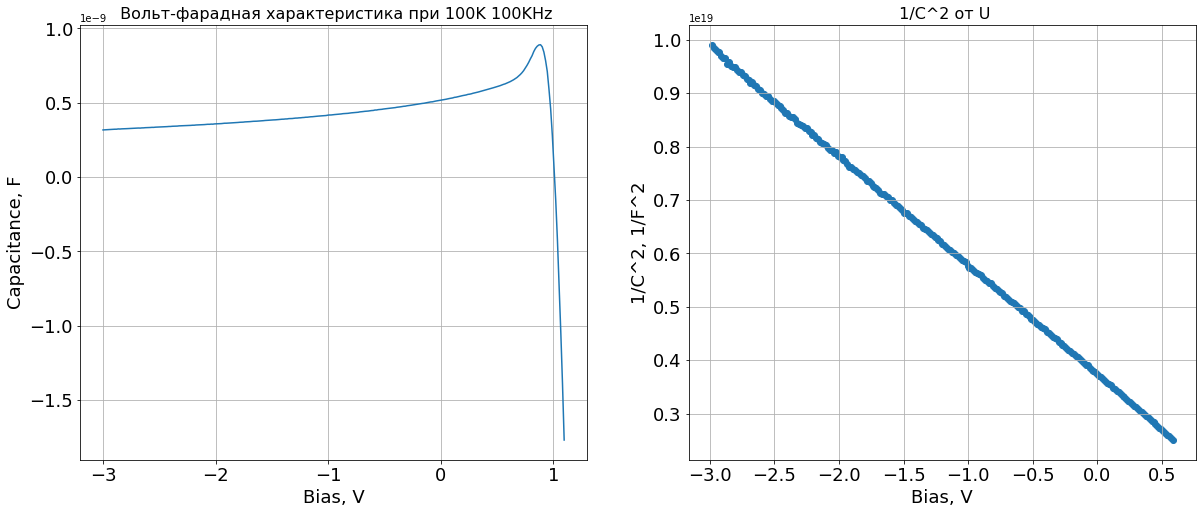

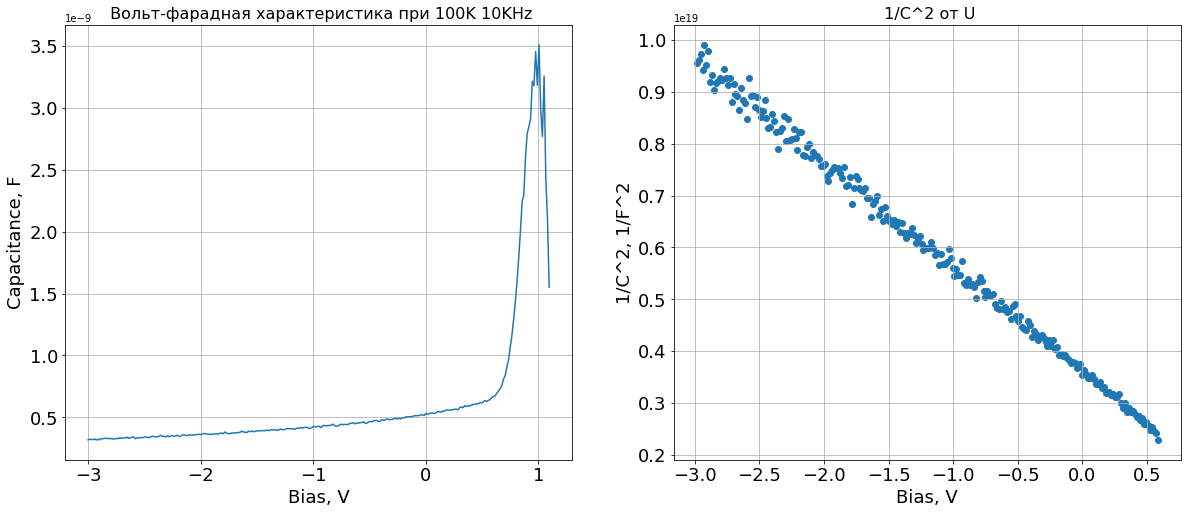

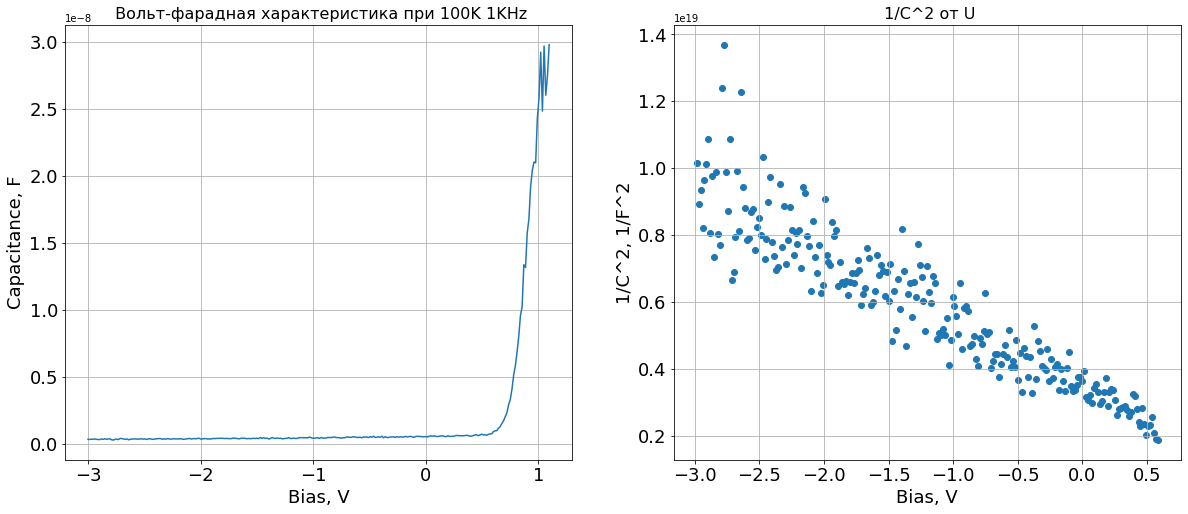

In [333]:
cv_plot(cap_list_100, 100, -6e-8, -3, 0.6)

In [354]:
##### limit_list_right = [0.7, 0.6, 0.6, 0.5]
limit_list_left = [-2, -2, -2, -2]
i = 0
print('При температуре 100К')
for item in cap_list_100:
    print('Параметры для частоты', freqs[i])
    params(item, limit_list_left[i], limit_list_right[i], i, Temps[i])
    i+=1
    print()

При температуре 100К
Параметры для частоты 1MHz
 
-1.906e+18 x + 3.33e+18
V_d =  -0.57 B
N_d = 7.63e+16
E_C - E_F =  0.015 eV

Параметры для частоты 100KHz
 
-2.043e+18 x + 3.733e+18
V_d =  -0.55 B
N_d = 7.11e+16
E_C - E_F =  0.025 eV

Параметры для частоты 10KHz
 
-2.004e+18 x + 3.611e+18
V_d =  -0.55 B
N_d = 7.25e+16
E_C - E_F =  0.031 eV

Параметры для частоты 1KHz
 
-1.987e+18 x + 3.455e+18
V_d =  -0.58 B
N_d = 7.31e+16
E_C - E_F =  0.019 eV



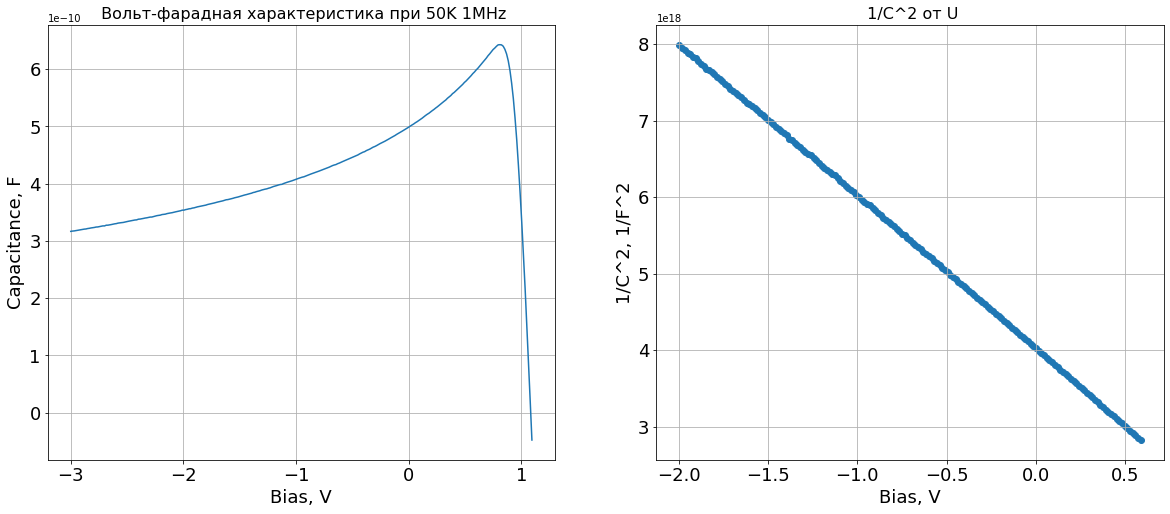

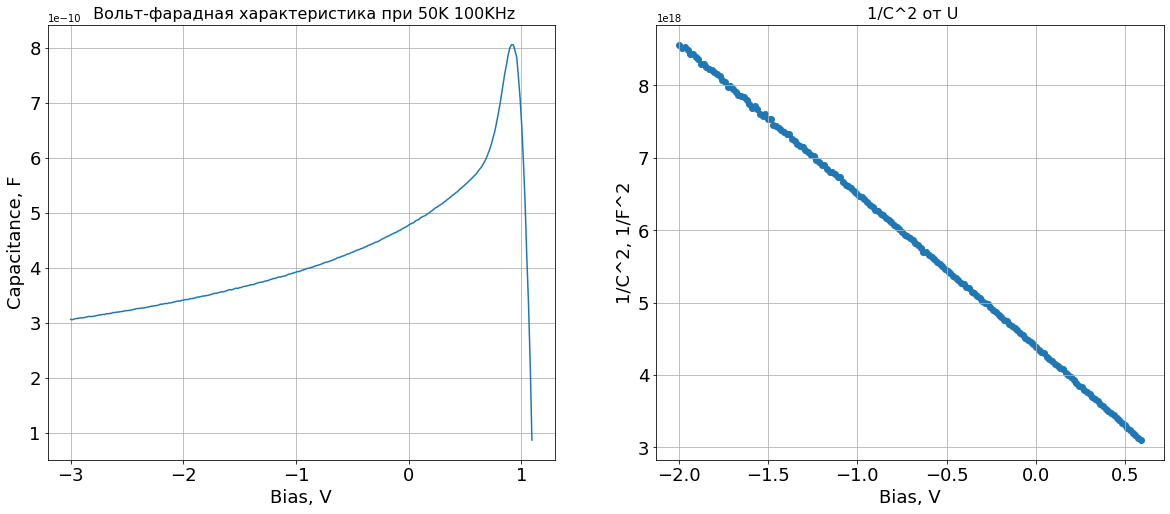

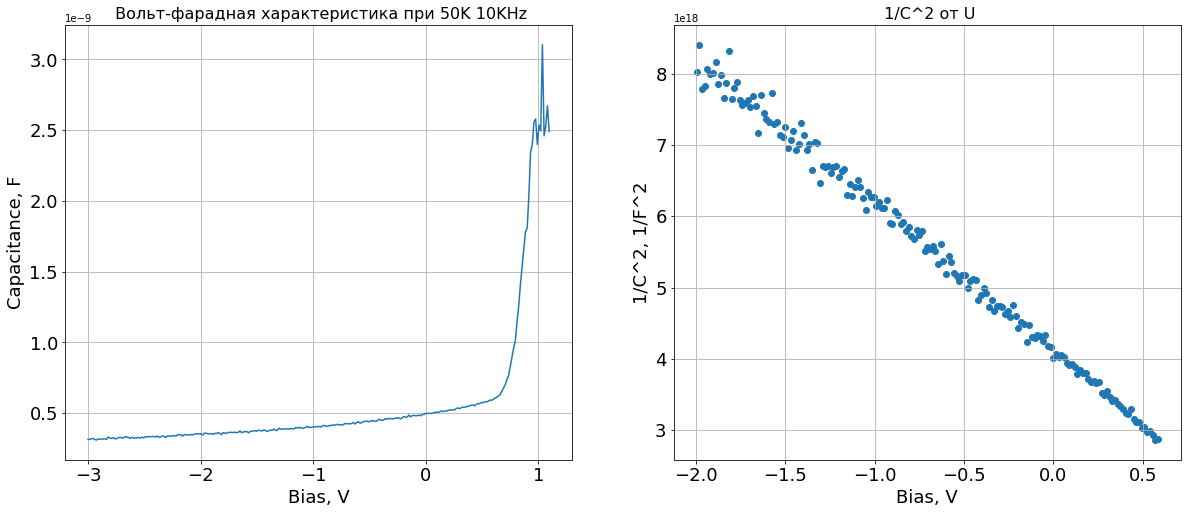

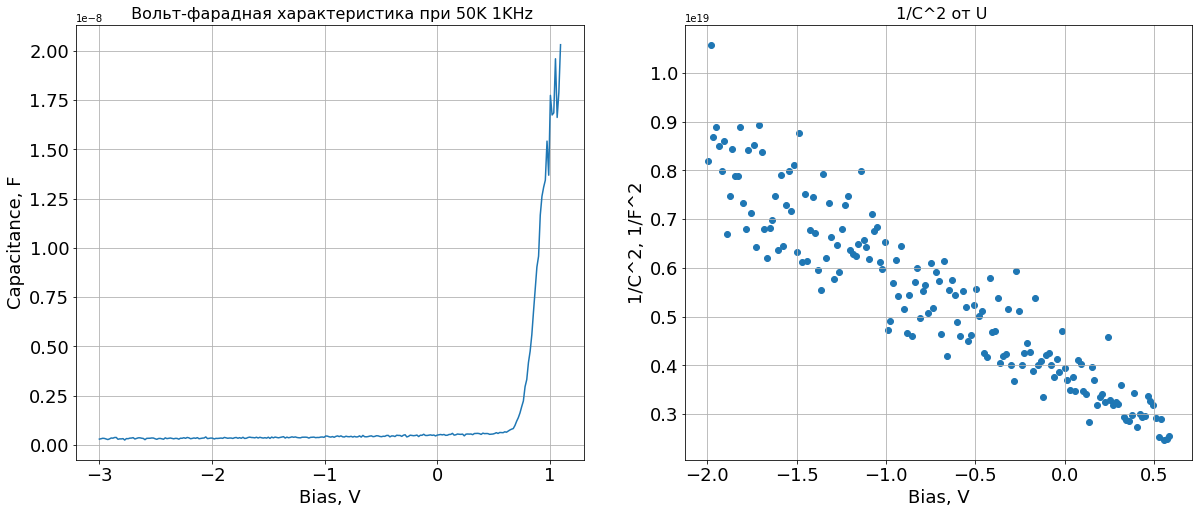

In [335]:
cv_plot(cap_list_50, 50, -6e-8, -2, 0.6)

In [336]:
limit_list_right = [0.7, 0.6, 0.6, 0.5]
limit_list_left = [-2, -2, -2, -2]
i = 0
print('При температуре 50К')
for item in cap_list_50:
    print('Параметры для частоты', freqs[i])
    params(item, limit_list_left[i], limit_list_right[i], i, Temps[i])
    i+=1
    print()

При температуре 50К
Параметры для частоты 1MHz
 
-1.999e+18 x + 4.016e+18
V_d =  -0.5 B
N_d = 7.27e+16
E_C - E_F =  0.015 eV

Параметры для частоты 100KHz
 
-2.112e+18 x + 4.381e+18
V_d =  -0.48 B
N_d = 6.88e+16
E_C - E_F =  0.025 eV

Параметры для частоты 10KHz
 
-2.05e+18 x + 4.118e+18
V_d =  -0.5 B
N_d = 7.09e+16
E_C - E_F =  0.031 eV

Параметры для частоты 1KHz
 
-2.177e+18 x + 3.881e+18
V_d =  -0.56 B
N_d = 6.68e+16
E_C - E_F =  0.021 eV



Уравненение апроксимационной прямой при T=300 K  
18.93 x - 19.64
Рассчитанные параметры:
I_0 =  2.95e-09 A
R =  0.05 Ohm
phi_b =  -0.96 V
Уравненение апроксимационной прямой при T=200 K  
22.9 x - 24.96
Рассчитанные параметры:
I_0 =  1.45e-11 A
R =  0.04 Ohm
phi_b =  -0.92 V
Уравненение апроксимационной прямой при T=100 K  
23.04 x - 27.35
Рассчитанные параметры:
I_0 =  1.32e-12 A
R =  0.04 Ohm
phi_b =  -0.84 V
Уравненение апроксимационной прямой при T=50 K  
23.27 x - 29.42
Рассчитанные параметры:
I_0 =  1.68e-13 A
R =  0.04 Ohm
phi_b =  -0.79 V


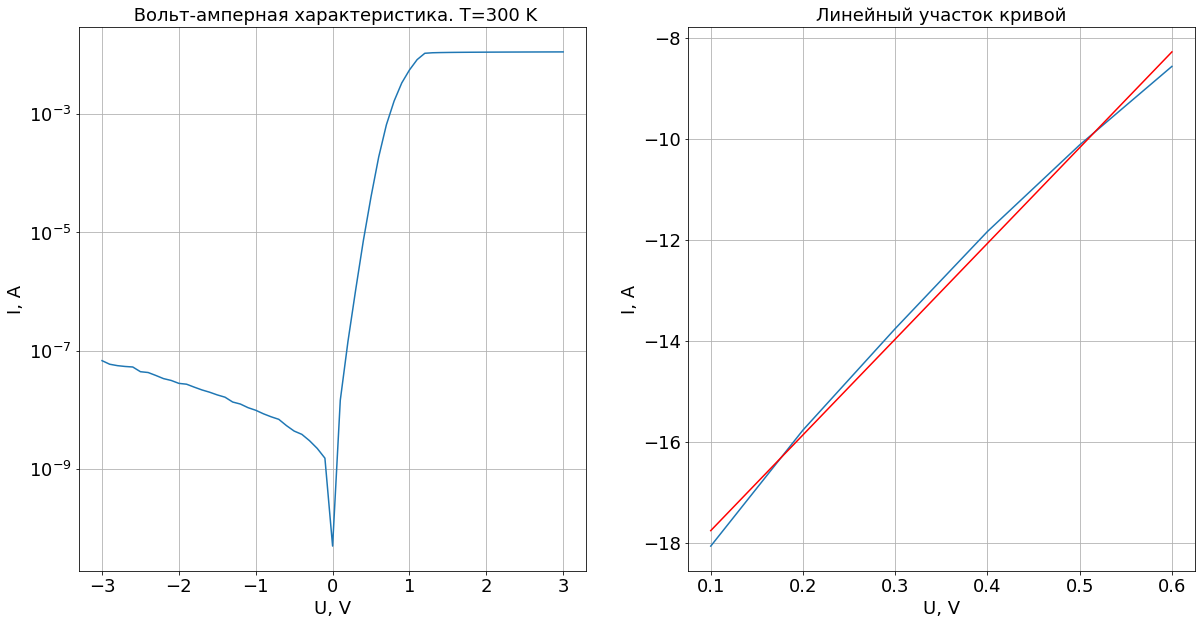

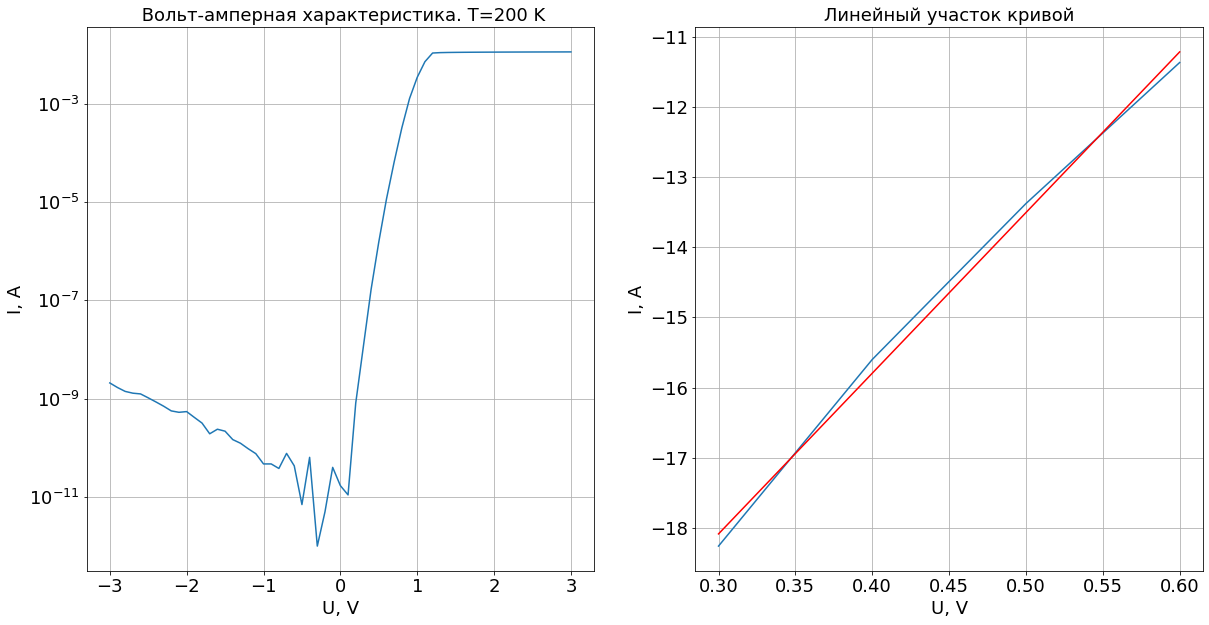

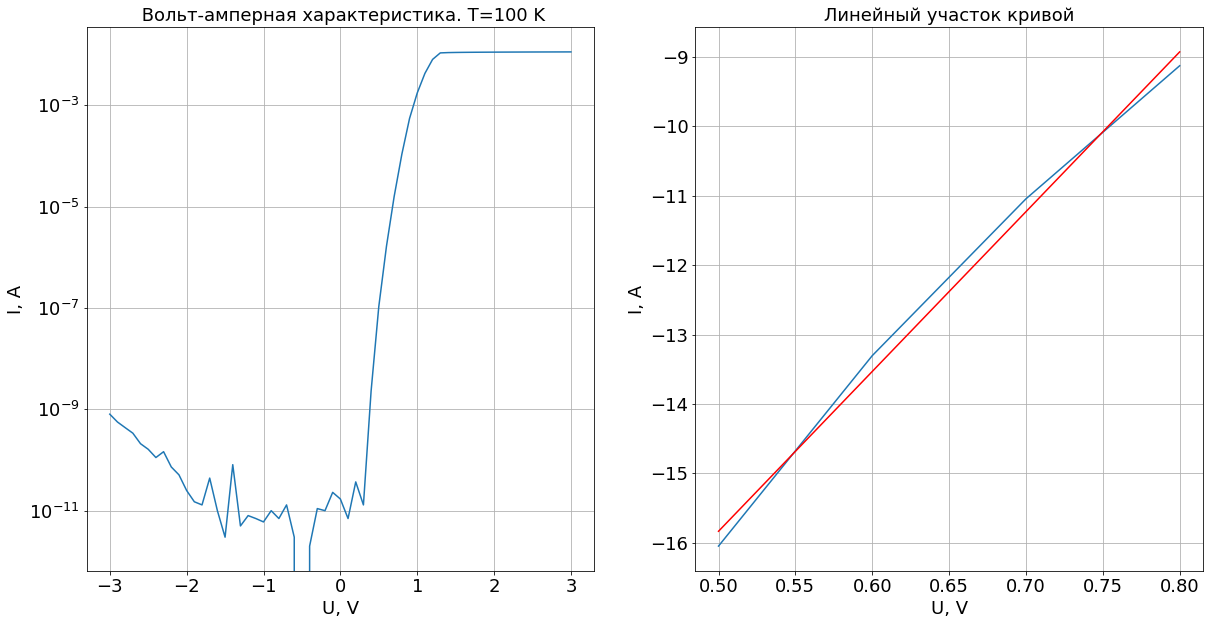

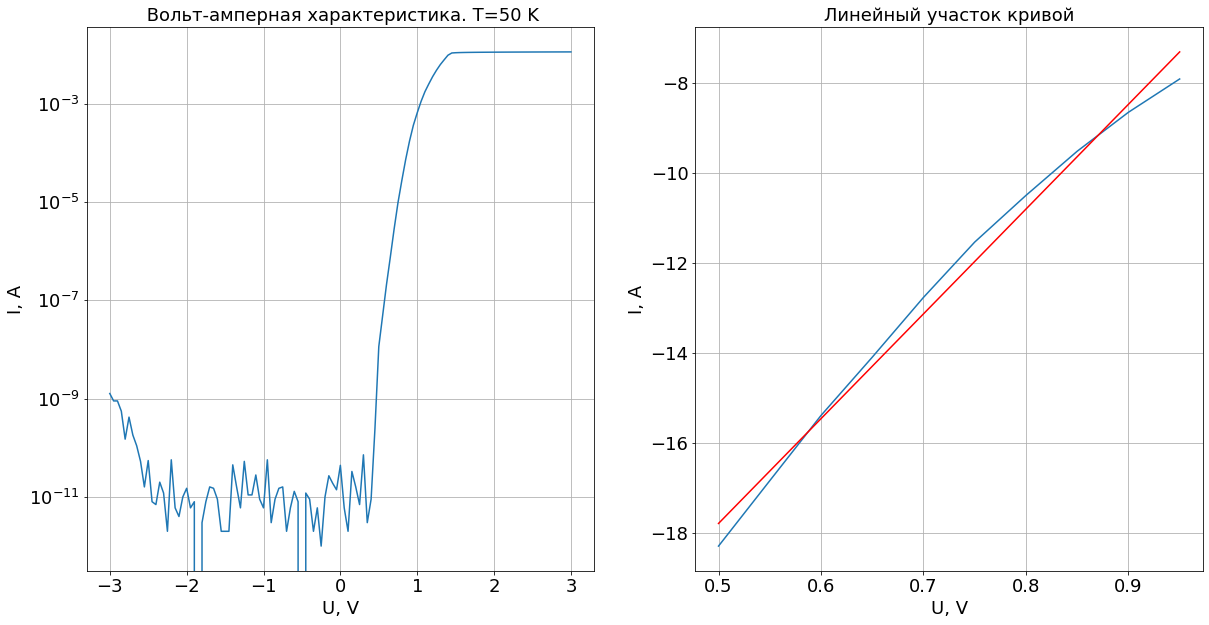

In [308]:
VAC_plot(VAC_300, 0, 0.65, 300)

VAC_plot(VAC_200, 0.2, 0.7, 200)

VAC_plot(VAC_100, 0.45, 0.9, 100)

VAC_plot(VAC_50, 0.45, 1, 50)
